# Hybrid EEG-NIRS Classification

In [ ]:
#Install the necessary libraries
!pip install mne scipy matplotlib pandas scikit-learn numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 15.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import the necessary libraries
import mne
import numpy as np
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt

# Specific libraries for machin learning models (here, LDA and SVM)
from mlxtend.feature_selection import ColumnSelector
from mne.decoding import CSP
from mne.decoding import Vectorizer, get_coef
from mne.decoding import LinearModel

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_val_predict
from mlxtend.classifier import StackingCVClassifier

# Specific for EEGNet
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')
import sys, os

from keras.layers import Input
from keras.layers import Input, Conv2D, BatchNormalization, DepthwiseConv2D, Activation, AveragePooling2D, SeparableConv2D, Flatten, Dense
from keras.models import Model
from keras.regularizers import l2
from keras.layers import Dropout

# **Signal Processing and Visualization**

## NIRS Data

In [ ]:
#Specify cnt NIRS data
file = '/content/drive/MyDrive/Thesis NIRS/Subject 5/cnt.mat'

#Convert from MATLAB format into pandas DataFrame
nirs_matlab_files = loadmat(file)
nirs_channels = [item.flat[0] for item in nirs_matlab_files['cnt'][0][0]['clab'][0][0][0]]

#Load montage data
mnt = loadmat('/content/drive/MyDrive/Thesis NIRS/Subject 5/mnt.mat')
pos_3d = (mnt['mnt']['pos_3d'][0][0].T)/10
#Load source info
sources = (mnt['mnt']['source'][0][0][0][0][2].T)/10
#Load detector info
detectors = (mnt['mnt']['detector'][0][0][0][0][2].T)/10
#Source-detector pairs
pairs = mnt['mnt']['sd'][0][0]

In [ ]:
#Set new regular expressions for channel names
n_channels = ['S2_D1 760','S2_D1 850','S3_D1 760','S3_D1 850','S3_D2 760','S3_D2 850','S4_D1 760',
              'S4_D1 850','S4_D2 760','S4_D2 850','S4_D3 760','S4_D3 850','S5_D2 760','S5_D2 850',
              'S5_D3 760','S5_D3 850','S6_D3 760','S6_D3 850','S7_D4 760','S7_D4 850','S7_D6 760',
              'S7_D6 850','S7_D7 760','S7_D7 850','S9_D5 760','S9_D5 850','S9_D9 760','S9_D9 850',
              'S9_D10 760','S9_D10 850','S10_D9 760','S10_D9 850','S10_D10 760','S10_D10 850',
              'S10_D11 760','S10_D11 850','S11_D5 760','S11_D5 850','S11_D10 760','S11_D10 850',
              'S11_D12 760','S11_D12 850','S12_D10 760','S12_D10 850','S12_D11 760','S12_D11 850',
              'S12_D12 760','S12_D12 850','S13_D13 760','S13_D13 850','S13_D14 760','S13_D14 850',
              'S13_D15 760','S13_D15 850','S14_D13 760','S14_D13 850','S14_D15 760','S14_D15 850',
              'S14_D16 760','S14_D16 850','S15_D8 760','S15_D8 850','S15_D14 760','S15_D14 850',
              'S15_D15 760','S15_D15 850','S16_D8 760','S16_D8 850','S16_D15 760','S16_D15 850',
              'S16_D16 760','S16_D16 850']

In [ ]:
# Initialize an info structure
info = mne.create_info(
    ch_names=n_channels,
    ch_types=['fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude',
             'fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude',
             'fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude',
             'fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude',
             'fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude',
             'fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude',
             'fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude',
             'fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude',
             'fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude',
             'fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude',
             'fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude',
             'fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude','fnirs_cw_amplitude'],
    sfreq=int(10))

In [ ]:
#Manually assign 3D coordinates to the info structure
x=0
for ch in range(36):
    for coor in range(3):
        info['chs'][x]['loc'][coor] = pos_3d[ch][coor]
        info['chs'][x+1]['loc'][coor] = pos_3d[ch][coor]
    x+=2

In [ ]:
#Assign source locations
x=0
for ch in range(36):
    for coor in range(3):
        info['chs'][x]['loc'][coor+3] = sources[pairs[ch][0]-1][coor]
        info['chs'][x+1]['loc'][coor+3] = sources[pairs[ch][0]-1][coor]
    x+=2

In [ ]:
#Assign detector locations

x=0
for ch in range(36):
    for coor in range(3):
        info['chs'][x]['loc'][coor+6] = detectors[pairs[ch][1]-1][coor]
        info['chs'][x+1]['loc'][coor+6] = detectors[pairs[ch][1]-1][coor]
    x+=2

In [ ]:
#Assign wavelengths
for x in info['chs'][0::2]:
    x['loc'][9] = 760

for x in info['chs'][1::2]:
    x['loc'][9] = 850

In [ ]:
#Data divided in three sessions
nirs_matcnt = {}
x=0

for i in range(3):
    nirs_matcnt["session{0}".format(i+1)] = pd.DataFrame([[row.flat[0] for row in line] for line
                                                        in nirs_matlab_files['cnt'][0][x]['x'][0][0]],
                                                        columns=nirs_channels)
    x+=2

#Reorder columns to have same source-detector pairs and both wavelenghts together
for i in range(3):
    nirs_matcnt["session{0}".format(i+1)]=nirs_matcnt["session{0}".format(i+1)][['AF7Fp1lowWL','AF7Fp1highWL','AF3Fp1lowWL',
                                                                     'AF3Fp1highWL','AF3AFzlowWL','AF3AFzhighWL',
                                                                     'FpzFp1lowWL','FpzFp1highWL','FpzAFzlowWL',
                                                                     'FpzAFzhighWL','FpzFp2lowWL','FpzFp2highWL',
                                                                     'AF4AFzlowWL','AF4AFzhighWL','AF4Fp2lowWL',
                                                                     'AF4Fp2highWL','AF8Fp2lowWL','AF8Fp2highWL',
                                                                     'OzPOzlowWL','OzPOzhighWL','OzO1lowWL',
                                                                     'OzO1highWL','OzO2lowWL','OzO2highWL',
                                                                     'C5CP5lowWL','C5CP5highWL','C5FC5lowWL',
                                                                     'C5FC5highWL','C5C3lowWL','C5C3highWL',
                                                                     'FC3FC5lowWL','FC3FC5highWL','FC3C3lowWL',
                                                                     'FC3C3highWL','FC3FC1lowWL','FC3FC1highWL',
                                                                     'CP3CP5lowWL','CP3CP5highWL','CP3C3lowWL',
                                                                     'CP3C3highWL','CP3CP1lowWL','CP3CP1highWL',
                                                                     'C1C3lowWL','C1C3highWL','C1FC1lowWL','C1FC1highWL',
                                                                     'C1CP1lowWL','C1CP1highWL','C2FC2lowWL','C2FC2highWL',
                                                                     'C2CP2lowWL','C2CP2highWL','C2C4lowWL','C2C4highWL',
                                                                     'FC4FC2lowWL','FC4FC2highWL','FC4C4lowWL','FC4C4highWL',
                                                                     'FC4FC6lowWL','FC4FC6highWL','CP4CP6lowWL','CP4CP6highWL',
                                                                     'CP4CP2lowWL','CP4CP2highWL','CP4C4lowWL','CP4C4highWL',
                                                                     'C6CP6lowWL','C6CP6highWL','C6C4lowWL','C6C4highWL',
                                                                        'C6FC6lowWL','C6FC6highWL']]

### Creating Raw Objects for MNE compatable

In [ ]:
nirs_raw = {}

#Create raw objects with the new channel names
nirs_raw["session1"] = mne.io.RawArray(nirs_matcnt["session1"].T, info)
nirs_raw["session2"] = mne.io.RawArray(nirs_matcnt["session2"].T, info)
nirs_raw["session3"] = mne.io.RawArray(nirs_matcnt["session3"].T, info)

Creating RawArray with float64 data, n_channels=72, n_times=7144
    Range : 0 ... 7143 =      0.000 ...   714.300 secs
Ready.
Creating RawArray with float64 data, n_channels=72, n_times=7224
    Range : 0 ... 7223 =      0.000 ...   722.300 secs
Ready.
Creating RawArray with float64 data, n_channels=72, n_times=7148
    Range : 0 ... 7147 =      0.000 ...   714.700 secs
Ready.


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 204.800 (s)


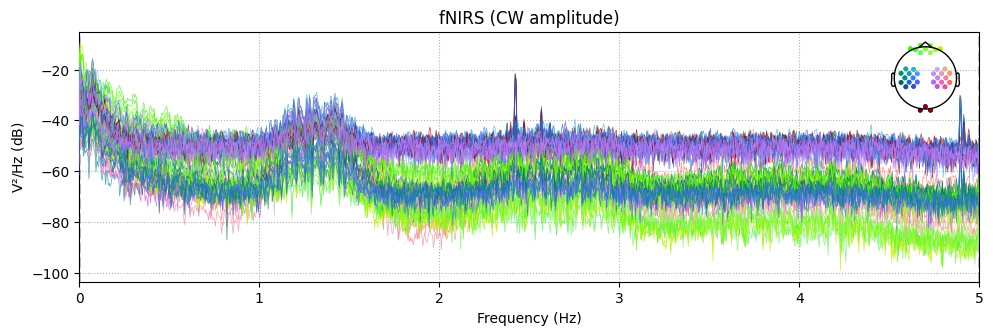

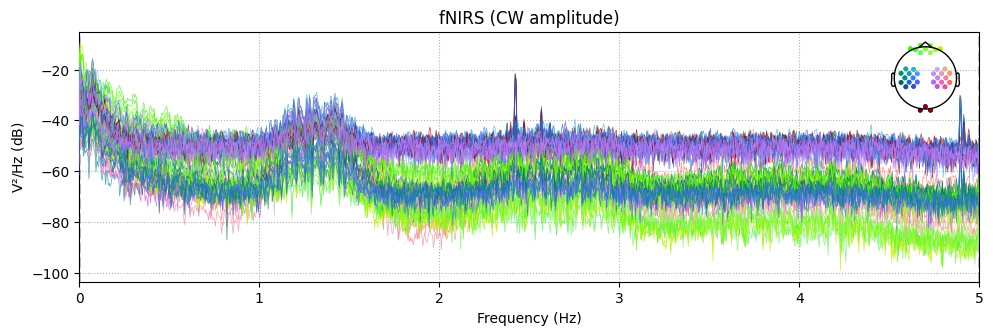

In [ ]:
nirs_raw["session2"].plot_psd()

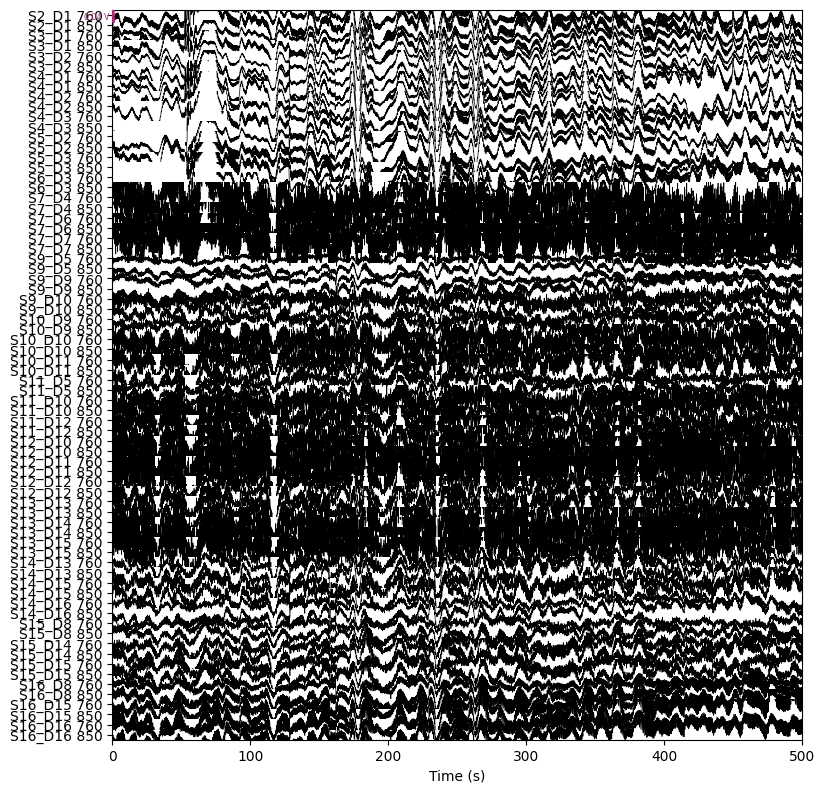

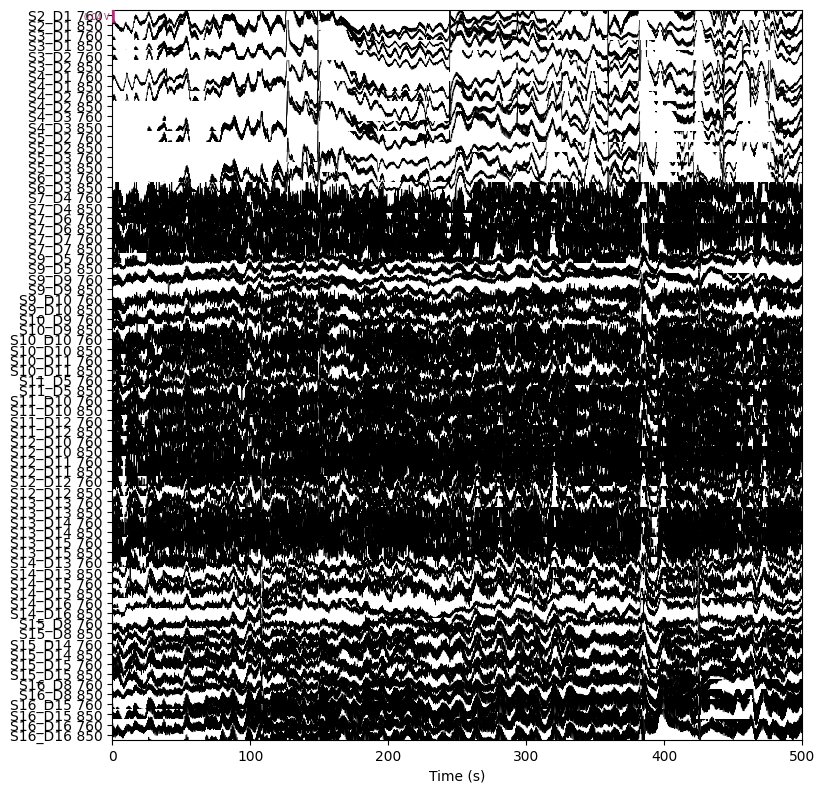

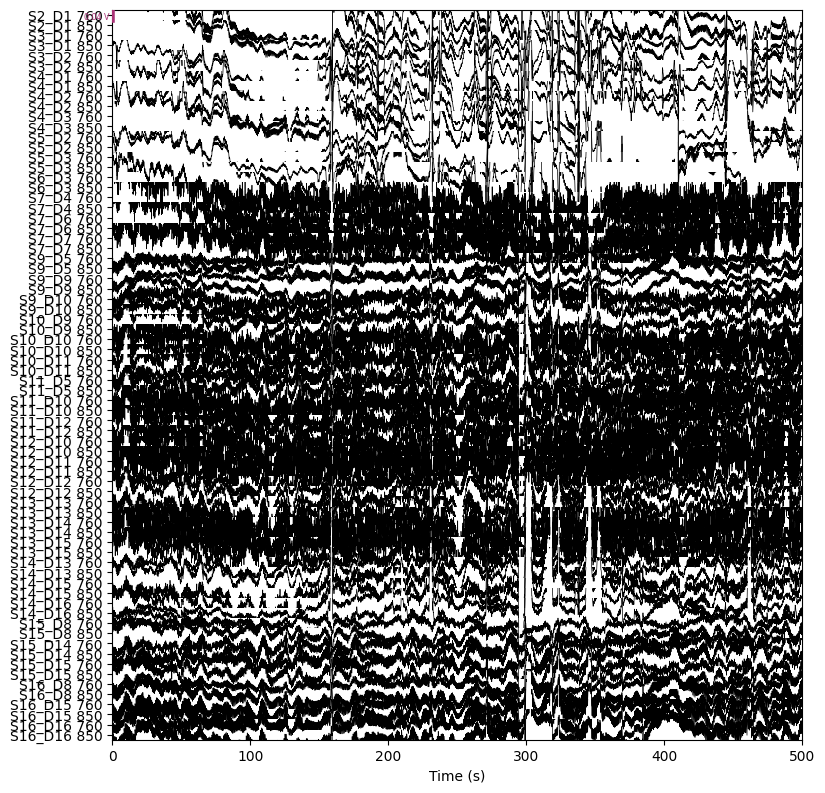

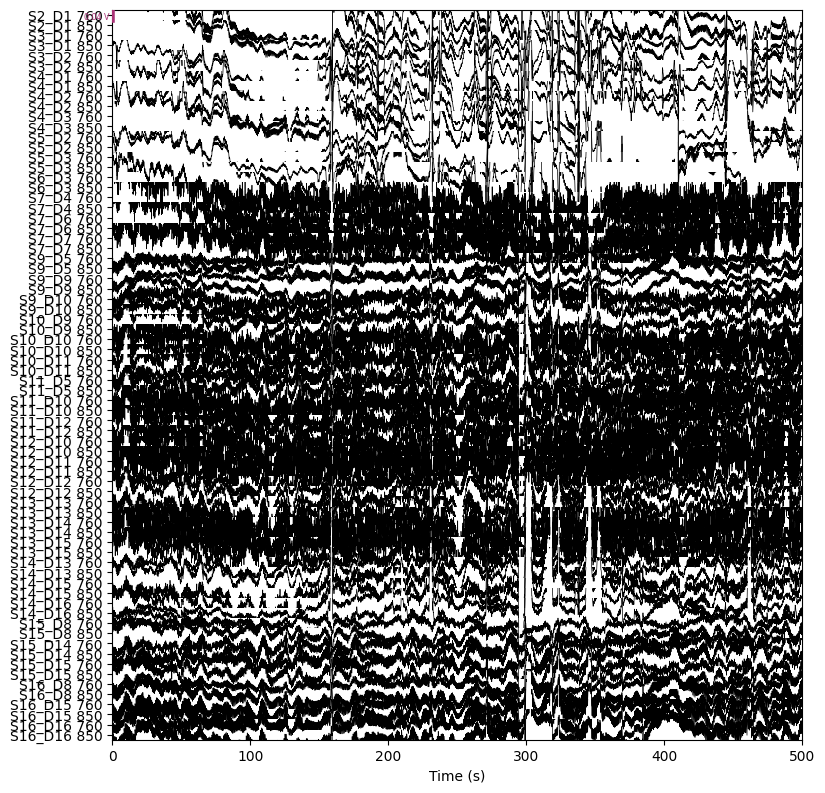

In [ ]:
#Converting from light intensity to optical density
raw_od1 = mne.preprocessing.nirs.optical_density(nirs_raw["session1"])
raw_od2 = mne.preprocessing.nirs.optical_density(nirs_raw["session2"])
raw_od3 = mne.preprocessing.nirs.optical_density(nirs_raw["session3"])

raw_od1.plot(n_channels=len(raw_od1.ch_names),
            duration=500, show_scrollbars=False)
raw_od2.plot(n_channels=len(raw_od2.ch_names),
            duration=500, show_scrollbars=False)
raw_od3.plot(n_channels=len(raw_od3.ch_names),
            duration=500, show_scrollbars=False)

In [ ]:
#Convert from optical density to HbO and HbR concentrations
raw1_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od1)
raw2_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od2)
raw3_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od3)

raw1_haemo.plot(n_channels=len(raw1_haemo.ch_names),
               duration=500, show_scrollbars=False)
raw2_haemo.plot(n_channels=len(raw2_haemo.ch_names),
               duration=500, show_scrollbars=False)
raw3_haemo.plot(n_channels=len(raw3_haemo.ch_names),
               duration=500, show_scrollbars=False)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 204.800 (s)
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 3301 samples (330.100 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 204.800 (s)


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


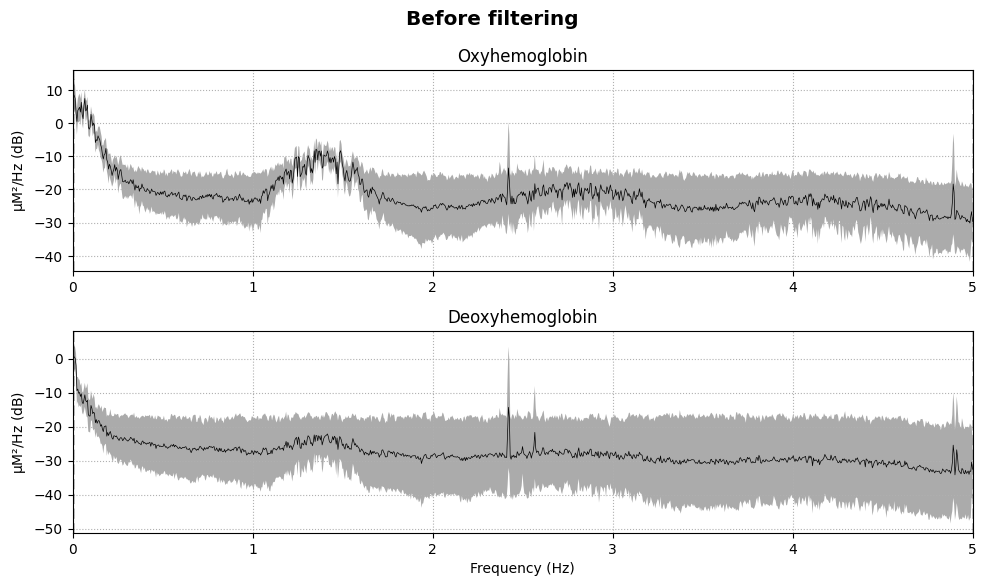

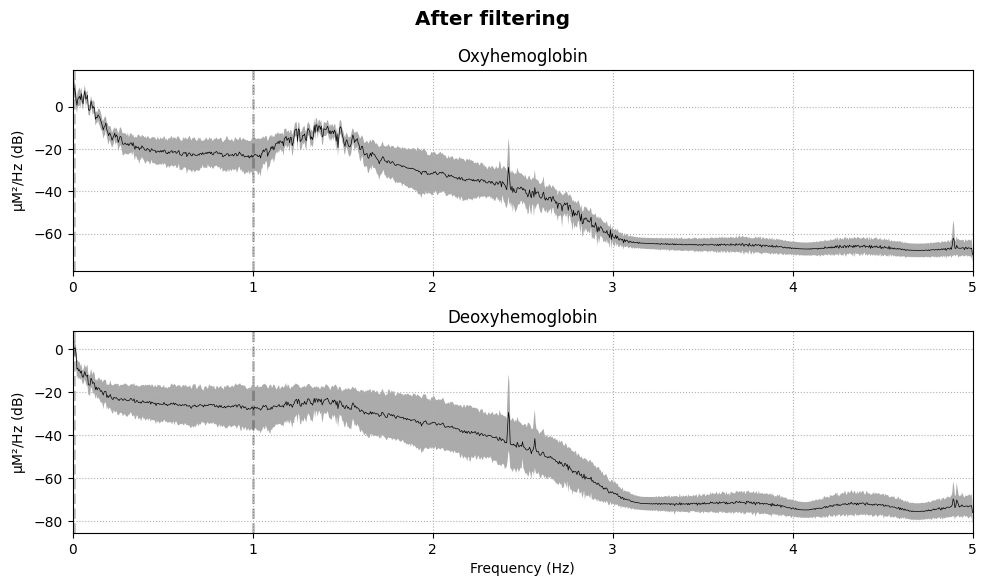

In [ ]:
#Band-pass HbO and HbR from 0.01Hz to 0.1 Hz
fig = raw1_haemo.plot_psd(average=True)
fig.suptitle('Before filtering', weight='bold', size='x-large')
fig.subplots_adjust(top=0.88)
raw1_haemo = raw1_haemo.filter(0.01,1, h_trans_bandwidth='auto',
                             l_trans_bandwidth='auto')
raw2_haemo = raw2_haemo.filter(0.01,1, h_trans_bandwidth='auto',
                             l_trans_bandwidth='auto')
raw3_haemo = raw3_haemo.filter(0.01,1, h_trans_bandwidth='auto',
                             l_trans_bandwidth='auto')
fig = raw1_haemo.plot_psd(average=True)
fig.suptitle('After filtering', weight='bold', size='x-large')
fig.subplots_adjust(top=0.88)

In [ ]:
#Passing through Notch filter to remove the powerline noise
raw1_haemo = raw1_haemo.notch_filter(freqs=[2.3])
raw2_haemo = raw2_haemo.notch_filter(freqs=[2.3])
raw3_haemo = raw3_haemo.notch_filter(freqs=[2.3])

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 1.8 - 2.8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.79
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 1.54 Hz)
- Upper passband edge: 2.81 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 3.06 Hz)
- Filter length: 67 samples (6.700 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 1.8 - 2.8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.79
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 1.54 Hz)
- Upper passband edge: 2.81 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 3.06 Hz)
- Filter length: 67 samples (6.700 s)



[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 1.8 - 2.8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.79
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 1.54 Hz)
- Upper passband edge: 2.81 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 3.06 Hz)
- Filter length: 67 samples (6.700 s)



[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 204.800 (s)


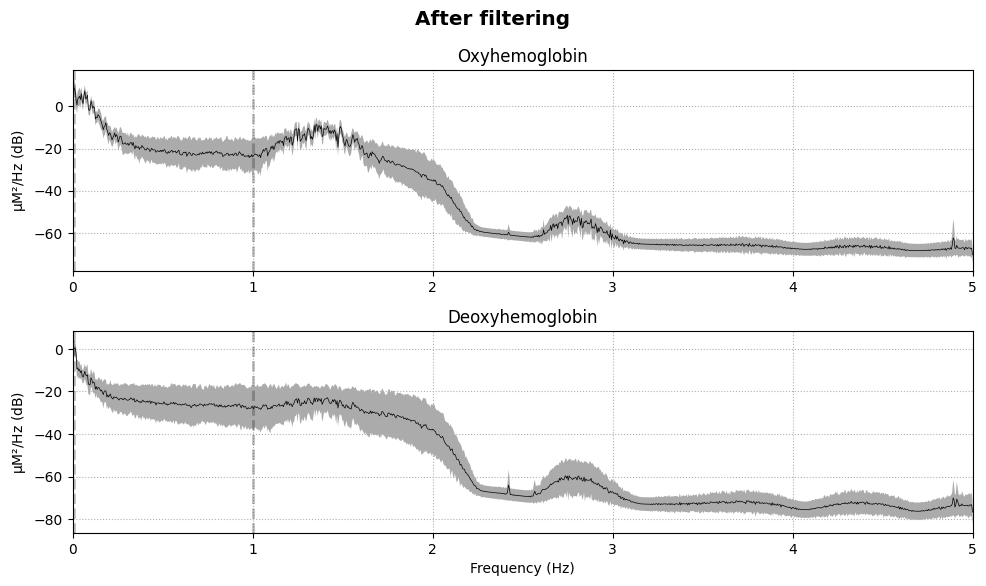

In [ ]:
#PSD plotting after passing through notch filter
fig = raw1_haemo.plot_psd(average=True)
fig.suptitle('After filtering', weight='bold', size='x-large')
fig.subplots_adjust(top=0.88)

### Epoching

In [ ]:
#Extracting Epochs
filename = '/content/drive/MyDrive/Thesis NIRS/Subject 5/mrk.mat'
matlab_mrk = loadmat(filename)
nirs_events1=np.transpose(np.vstack(
        ((matlab_mrk['mrk'][0][0][0][0][0][0])/100,
         np.vstack((np.zeros(20),np.transpose(matlab_mrk['mrk'][0][0][0][0][1][0][0][0])[0])))))
nirs_events2=np.transpose(np.vstack(
        ((matlab_mrk['mrk'][0][2][0][0][0][0])/100,
         np.vstack((np.zeros(20),np.transpose(matlab_mrk['mrk'][0][2][0][0][1][0][0][0])[0])))))
nirs_events3=np.transpose(np.vstack(
        ((matlab_mrk['mrk'][0][4][0][0][0][0])/100,
         np.vstack((np.zeros(20),np.transpose(matlab_mrk['mrk'][0][4][0][0][1][0][0][0])[0])))))

#Information about the events
event_id = dict(LMI=1, RMI=2)

In [ ]:
#Create epochs objects and perform Baseline correction
nirs_epochs1 = mne.Epochs(raw1_haemo, events=nirs_events1.astype(int),tmin=-5,tmax=5,
                     event_id=event_id,proj=True, baseline=(-5, -2),
                     preload=True,detrend=None, verbose=True)
nirs_epochs2 = mne.Epochs(raw1_haemo,  events=nirs_events2.astype(int),tmin=-5,tmax=5,
                     event_id=event_id,proj=True, baseline=(-5, -2),
                     preload=True,detrend=None, verbose=True)
nirs_epochs3 = mne.Epochs(raw1_haemo, events=nirs_events3.astype(int),tmin=-5,tmax=5,
                     event_id=event_id,proj=True, baseline=(-5, -2),
                     preload=True,detrend=None, verbose=True)

#Concatenate raws
epochs = mne.concatenate_epochs((nirs_epochs1,nirs_epochs2,nirs_epochs3),add_offset=True)

In [ ]:
epochs.plot()

In [ ]:
#Separate hbo and hbr
epochs_hbo = epochs.copy().pick(list(range(0, 48,2)))
epochs_hbr = epochs.copy().pick(list(range(1, 48,2)))

## EEG Data

In [ ]:
#Save filepath of subject 19
filepath = '/content/drive/MyDrive/Thesis EEG/Subject 5/cnt.mat'

#Convert from MATLAB FORMAT to pd DataFrame
eeg_matlab = loadmat(filepath)
eeg_channels = [item.flat[0] for item in eeg_matlab['cnt'][0][0]['clab'][0][0][0]]

#Upload montage data
mnt = loadmat('/content/drive/MyDrive/Thesis EEG/Subject 5/mnt.mat')
pos_3d = mnt['mnt']['pos_3d'][0][0].T
clab = {}
for i in range(32):
    clab[mnt['mnt']['clab'][0][0][0][i][0]]=pos_3d[i]
eeg_mnt = mne.channels.make_dig_montage(clab,coord_frame='head')

In [ ]:
# Initialize an info structure
eeg_info = mne.create_info(
    ch_names=eeg_channels,
    ch_types=['eeg','eeg','eeg','eeg','eeg','eeg',
             'eeg','eeg','eeg','eeg','eeg','eeg',
             'eeg','eeg','eeg','eeg','eeg','eeg',
             'eeg','eeg','eeg','eeg','eeg','eeg',
             'eeg','eeg','eeg','eeg','eeg','eeg',
             'eog','eog'],
    sfreq=200)

eeg_info.set_montage(eeg_mnt)

<ipython-input-41-8ae3eb3f6e09>:12: RuntimeWarning: Not setting positions of 2 eog channels found in montage:
['VEOG', 'HEOG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  eeg_info.set_montage(eeg_mnt)


<Info | 8 non-empty values
 bads: []
 ch_names: F7, AFF5h, F3, AFp1, AFp2, AFF6h, F4, F8, AFF1h, AFF2h, Cz, Pz, ...
 chs: 30 EEG, 2 EOG
 custom_ref_applied: False
 dig: 33 items (3 Cardinal, 30 EEG)
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 200.0 Hz
>

### Creating Raw Objects for MNE compatable

In [ ]:
#One different Raw object for each session of MI

eeg_data_1 = pd.DataFrame([[row.flat[0] for row in line] for line
                           in eeg_matlab['cnt'][0][0]['x'][0][0]],
                          columns=eeg_channels)
eeg_data_2 = pd.DataFrame([[row.flat[0] for row in line] for line
                           in eeg_matlab['cnt'][0][2]['x'][0][0]],
                          columns=eeg_channels)
eeg_data_3 = pd.DataFrame([[row.flat[0] for row in line] for line
                           in eeg_matlab['cnt'][0][4]['x'][0][0]],
                          columns=eeg_channels)
eeg_raw1 = mne.io.RawArray((eeg_data_1.T*.000001), eeg_info)
eeg_raw2 = mne.io.RawArray((eeg_data_2.T*.000001), eeg_info)
eeg_raw3 = mne.io.RawArray((eeg_data_3.T*.000001), eeg_info)

Creating RawArray with float64 data, n_channels=32, n_times=118844
    Range : 0 ... 118843 =      0.000 ...   594.215 secs
Ready.
Creating RawArray with float64 data, n_channels=32, n_times=120469
    Range : 0 ... 120468 =      0.000 ...   602.340 secs
Ready.
Creating RawArray with float64 data, n_channels=32, n_times=119457
    Range : 0 ... 119456 =      0.000 ...   597.280 secs
Ready.


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)


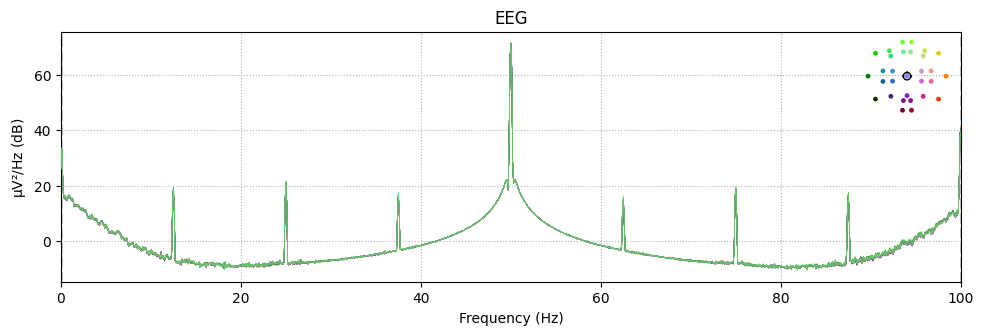

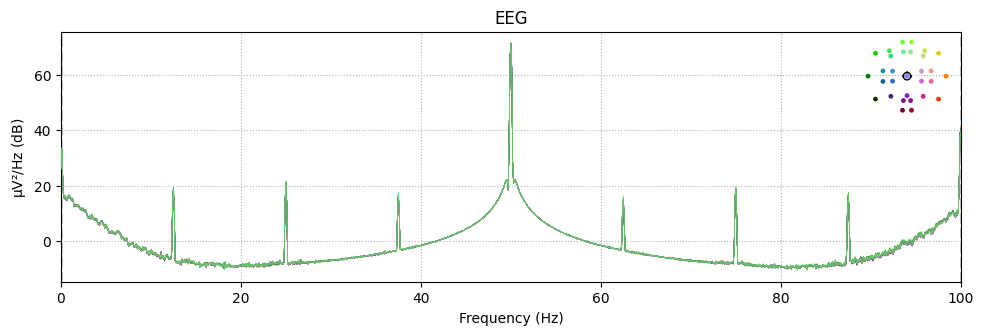

In [ ]:
eeg_raw1.plot_psd()

In [ ]:
#Passband filter from 0.5Hz to 50Hz
filtered_raw1 = eeg_raw1.filter(l_freq=0.5,
                                           h_freq=50, picks="all", filter_length='auto',
                                           l_trans_bandwidth='auto', h_trans_bandwidth='auto',
                                           fir_design='firwin')
filtered_raw2 = eeg_raw2.filter(l_freq=0.5, h_freq=50, picks="all", filter_length='auto',
                                           l_trans_bandwidth='auto', h_trans_bandwidth='auto',
                                           fir_design='firwin')
filtered_raw3 = eeg_raw3.copy().filter(l_freq=0.5, h_freq=50, picks="all", filter_length='auto',
                                           l_trans_bandwidth='auto', h_trans_bandwidth='auto',
                                           fir_design='firwin')

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)


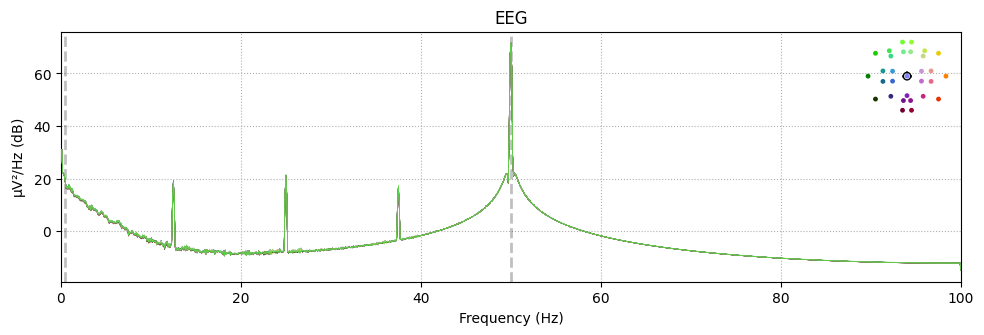

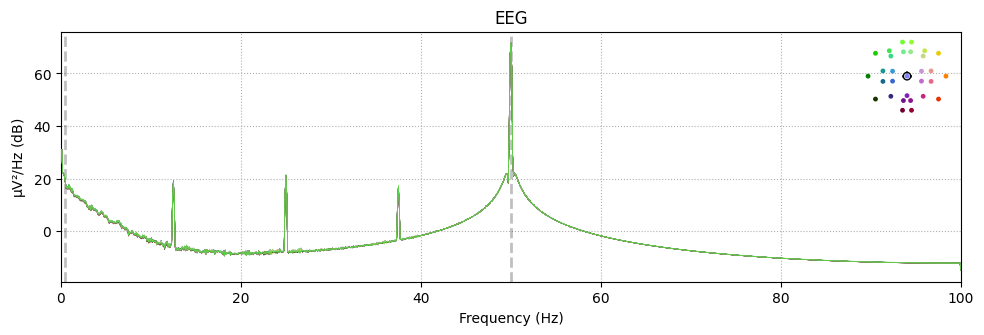

In [ ]:
filtered_raw1.plot_psd()

In [ ]:
#Passband filter from 8Hz to 25Hz
refiltered_raw1 = filtered_raw1.filter(l_freq=8, h_freq=25, picks="all", filter_length='auto',
                                       l_trans_bandwidth='auto',  h_trans_bandwidth='auto',
                                       fir_design='firwin')
refiltered_raw2 = filtered_raw2.filter(l_freq=8, h_freq=25, picks="all", filter_length='auto',
                                       l_trans_bandwidth='auto', h_trans_bandwidth='auto',
                                       fir_design='firwin')
refiltered_raw3 = filtered_raw3.filter(l_freq=8, h_freq=25, picks="all", filter_length='auto',
                                       l_trans_bandwidth='auto', h_trans_bandwidth='auto',
                                       fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 331 samples (1.655 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 25

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 331 samples (1.655 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)


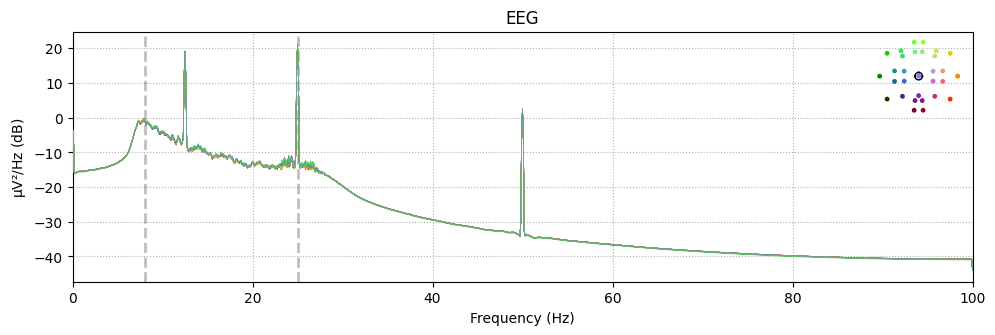

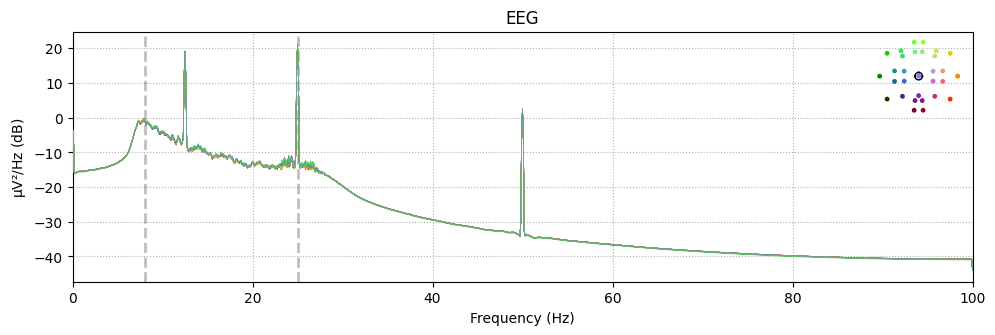

In [ ]:
refiltered_raw1.plot_psd()

In [ ]:
#Passing through Notch filter to remove the powerline noise
notch_filtered_raw1 = refiltered_raw1.notch_filter(freqs=[50])
notch_filtered_raw2 = refiltered_raw2.notch_filter(freqs=[50])
notch_filtered_raw3 = refiltered_raw3.notch_filter(freqs=[50])

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband e

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)


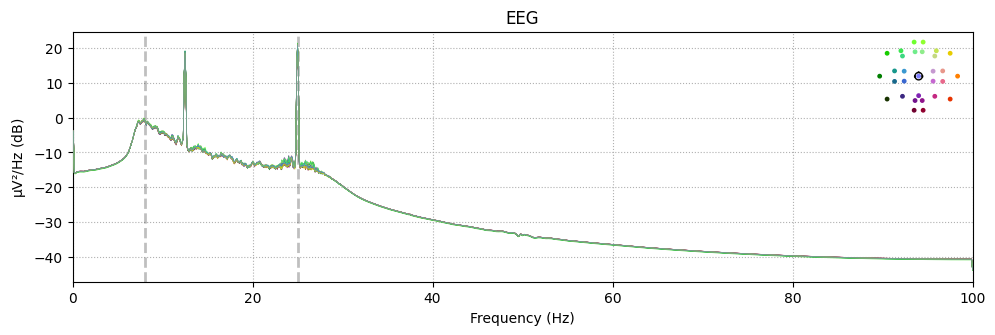

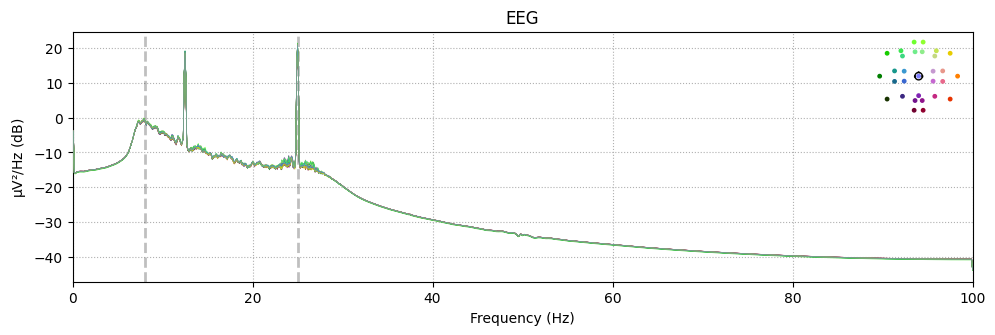

In [ ]:
notch_filtered_raw1.plot_psd()

### Epoching

In [ ]:
epo_filepath = '/content/drive/MyDrive/Thesis EEG/Subject 5/mrk.mat'
eeg_matlab_epochs = loadmat(epo_filepath)

eeg_events1=np.transpose(np.vstack(
        ((eeg_matlab_epochs['mrk'][0][0][0][0][0][0])/5,
         np.vstack((np.zeros(20),np.transpose(eeg_matlab_epochs['mrk'][0][0][0][0][1][0][0][0])[0])))))
eeg_events2=np.transpose(np.vstack(
        ((eeg_matlab_epochs['mrk'][0][2][0][0][0][0])/5,
         np.vstack((np.zeros(20),np.transpose(eeg_matlab_epochs['mrk'][0][2][0][0][1][0][0][0])[0])))))
eeg_events3=np.transpose(np.vstack(
        ((eeg_matlab_epochs['mrk'][0][4][0][0][0][0])/5,
         np.vstack((np.zeros(20),np.transpose(eeg_matlab_epochs['mrk'][0][4][0][0][1][0][0][0])[0])))))

#Change clabs to 1 for left motor-imagery and 2 for right motor-imagery
eeg_events1[eeg_events1 == 16] = 1
eeg_events2[eeg_events2 == 16] = 1
eeg_events3[eeg_events3 == 16] = 1
eeg_events1[eeg_events1 == 32] = 2
eeg_events2[eeg_events2 == 32] = 2
eeg_events3[eeg_events3 == 32] = 2

#Information about the events
event_id = dict(LMI=1, RMI=2)

In [ ]:
eeg_epochs1 = mne.Epochs(refiltered_raw1, eeg_events1.astype(int),
                         event_id=event_id,preload=True,proj=True,tmin=-1.,tmax=4.,
                         picks="eeg",baseline=None)
eeg_epochs2 = mne.Epochs(refiltered_raw2, eeg_events2.astype(int),
                         event_id=event_id,preload=True,proj=True,tmin=-1.,tmax=4.,
                         picks="eeg",baseline=None)
eeg_epochs3 = mne.Epochs(refiltered_raw3, eeg_events3.astype(int),
                         event_id=event_id,preload=True,proj=True,tmin=-1.,tmax=4.,
                         picks="eeg",baseline=None)

eeg_epochs = mne.concatenate_epochs((eeg_epochs1,eeg_epochs2,eeg_epochs3),add_offset=True)


Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 1001 original time points ...
0 bad epochs dropped
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 1001 original time points ...
0 bad epochs dropped
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 1001 original time points ...
0 bad epochs dropped
Not setting metadata
60 matching events found
No baseline correction applied


Using matplotlib as 2D backend.


<ipython-input-11-e0ca6149070e>:1: FutureWarning: The current default events=None is deprecated and will change to events=True in MNE 1.6. Set events=False to suppress this warning.
  eeg_epochs.plot()


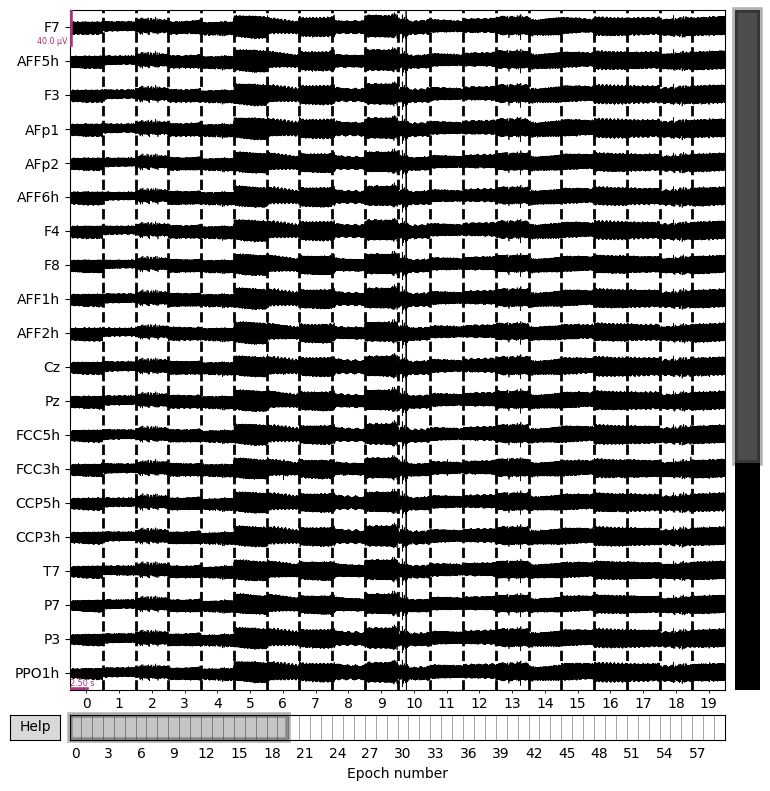

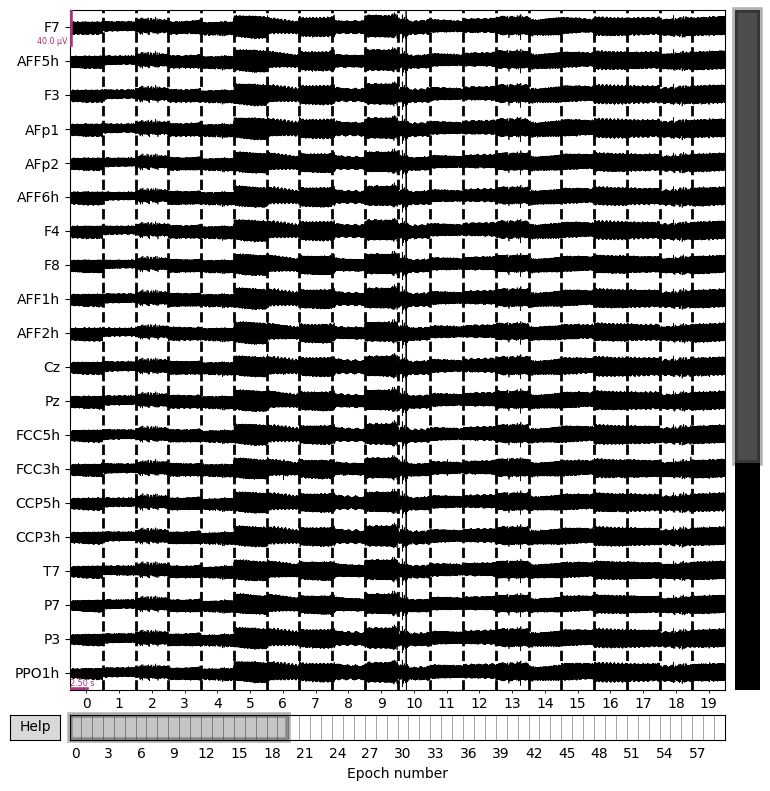

In [ ]:
eeg_epochs.plot()

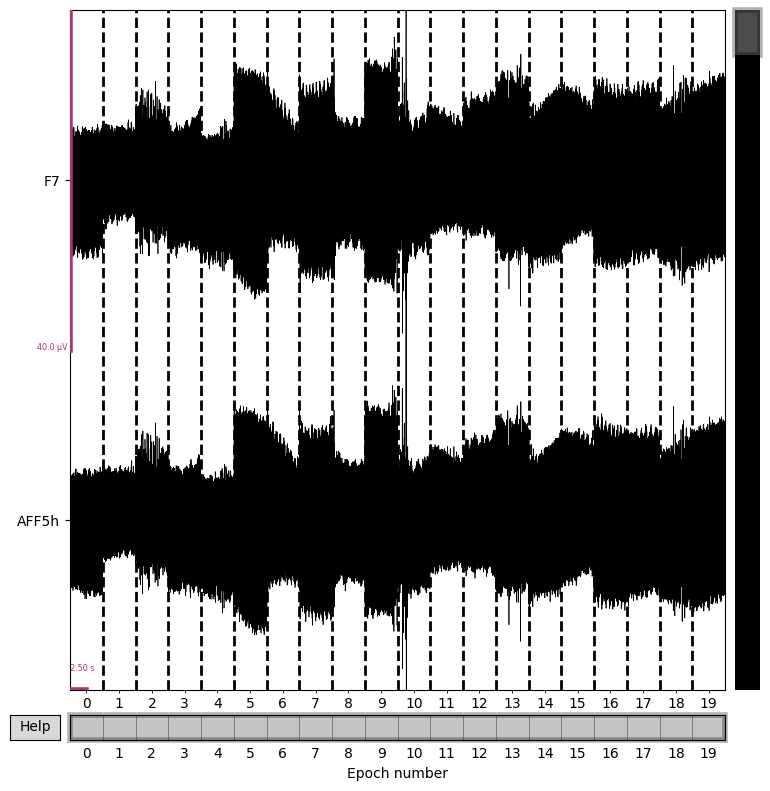

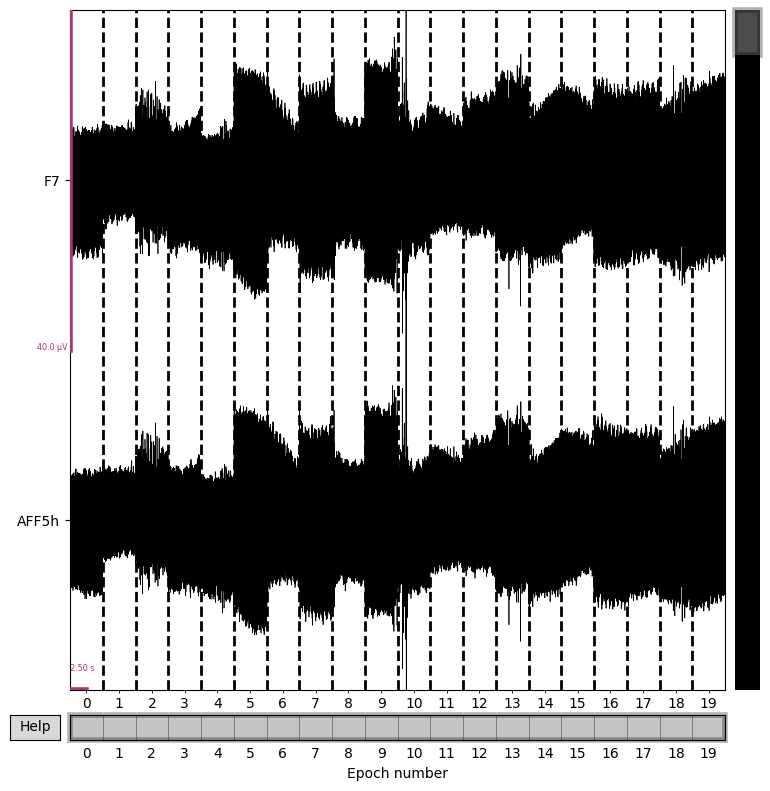

In [ ]:
mne.viz.plot_epochs(eeg_epochs[:20], n_channels=2)

## Common spatial pattern (CSP)

In [ ]:
test_eeg = eeg_epochs.copy()
test_nirs = x.copy()
# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs_train_eeg = test_eeg.copy().crop(tmin=1, tmax=2)
epochs_train_nirs = test_nirs.copy().crop(tmin=1, tmax=2)
labels_eeg = test_eeg.events[:, -1]
labels_nirs = test_nirs.events[:,-1]
# Implement cross validation later
scores = []
epochs_data_eeg = test_eeg.get_data() # Full data EEG
epochs_data_nirs = test_nirs.get_data() #Full data fused
epochs_data_train_eeg = epochs_train_eeg.get_data() #Train data EEG
epochs_data_train_nirs = epochs_train_nirs.get_data() #Train data fused
cv_eeg = ShuffleSplit(10, test_size=0.2, random_state=42) #Create 10 splits with 20% test size
cv_nirs = ShuffleSplit(10, test_size=0.2, random_state=42) #Create 10 splits with 20% test size
cv_split_eeg = cv_eeg.split(epochs_data_train_eeg) #Create splits from training data
cv_split_nirs = cv_nirs.split(epochs_data_train_nirs) #Create splits from training data NIRS
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# **LDA and SVM models**

**Apply CSP and LDA/SVM (EEG Only)**

In [ ]:
lda = LinearDiscriminantAnalysis(solver="lsqr",shrinkage='auto')

for train_idx, test_idx in cv_split_eeg:
    #print(train_idx, "testidx",test_idx)
    y_train_eeg, y_test_eeg = labels_eeg[train_idx], labels_eeg[test_idx] #Gets expected values (labels) of the training and testing
    y_train_nirs, y_test_nirs = labels_nirs[train_idx], labels_nirs[test_idx]
    #print(y_train_nirs,y_test_nirs)
    X_train_eeg = csp.fit_transform(epochs_data_train_eeg[train_idx],y_train_eeg)
    X_test_eeg = csp.transform(epochs_data_train_eeg[test_idx])
    #Reshape NIRS data as done in the Vectorize function
    X_train_nirs = epochs_data_train_nirs[train_idx].reshape(len(epochs_data_train_nirs[train_idx]),-1)
    X_test_nirs = epochs_data_train_nirs[test_idx].reshape(len(epochs_data_train_nirs[test_idx]),-1)
    #Training and Testing data
    X_train = X_train_eeg
    X_test = X_test_eeg #Events are the same so it's not necessary to concatenate
    y_train = y_train_eeg
    y_test = y_test_eeg
    lda.fit(X_train,y_train)
print("Accuracy of Hybrid BCI -",lda.score(X_test, y_test))

**Apply CSP and LDA/SVM (EEG and NIRS)**

In [ ]:
lda = LinearDiscriminantAnalysis(solver="lsqr",shrinkage='auto')

for train_idx, test_idx in cv_split_eeg:
    # print(train_idx, "testidx", test_idx)
    y_train_eeg, y_test_eeg = labels_eeg[train_idx], labels_eeg[test_idx] # Gets expected values (labels) of the training and testing
    y_train_nirs, y_test_nirs = labels_nirs[train_idx], labels_nirs[test_idx]
    # print(y_train_nirs, y_test_nirs)
    X_train_eeg = csp.fit_transform(epochs_data_train_eeg[train_idx], y_train_eeg)
    X_test_eeg = csp.transform(epochs_data_train_eeg[test_idx])

    # Reshape NIRS data as done in the Vectorize function
    X_train_nirs = epochs_data_train_nirs[train_idx].reshape(len(epochs_data_train_nirs[train_idx]), -1)
    X_test_nirs = epochs_data_train_nirs[test_idx].reshape(len(epochs_data_train_nirs[test_idx]), -1)

    # Check if the number of samples is the same for both modalities
    assert X_train_eeg.shape[0] == X_train_nirs.shape[0], "Inconsistent number of samples in EEG and NIRS data."

    # Fuse data
    X_train_combined = np.concatenate((X_train_eeg, X_train_nirs), axis=1)
    print(X_train_combined.shape)
    y_train_combined = y_train_eeg  # or y_train_nirs, since they are the same for both modalities
    print(y_train_combined.shape)

    X_test_combined = np.concatenate((X_test_eeg, X_test_nirs), axis=1)
    print(X_test_combined.shape)
    y_test_combined = y_test_eeg  # or y_test_nirs, since they are the same for both modalities
    print(y_test_combined.shape)

    lda.fit(X_train_combined, y_train_combined)

print("Accuracy of Hybrid BCI -", lda.score(X_test_combined, y_test_combined))


# **EEGNet**

**Data Preparation**

In [ ]:
# Make a copy of the eeg and nirs data
full_eeg = eeg_epochs.copy()
full_nirs = x.copy()
labels_eeg = full_eeg.events[:, -1]
labels_nirs = full_nirs.events[:,-1]
# Implement cross validation later
scores = []
epochs_data_eeg = full_eeg.get_data() # Full data EEG
epochs_data_nirs = full_nirs.get_data() #Full data nirs
# Fuse data
X_combined = np.concatenate((epochs_data_eeg, epochs_data_nirs), axis=1)
y_combined = labels_eeg  # or y_train_nirs, since they are the same for both modalities

# Convert y_combined into binary format (0 or 1)
y_combined_binary = (y_combined == 1).astype(int)

# One-hot encode the target labels (y_combined_binary)
y_onehot_binary = to_categorical(y_combined_binary, num_classes=2)


# Split the data into training and testing sets (95% for training, 5% for testing)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_onehot_binary, test_size=0.05, random_state=42, stratify=y_onehot_binary)

def min_max_scaler(epoch_data):
    # scales data to -1, 1
    max_abs = np.max(np.abs(epoch_data))
    processed_data = epoch_data / max_abs
    return processed_data

# Normalize the data using min-max scaling
X_train = min_max_scaler(X_train)
X_test = min_max_scaler(X_test)

# Reshape the data to match EEGNet input format
X_train = X_train.reshape(X_train.shape[0],  X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0],  X_test.shape[1], X_test.shape[2], 1)

# Define the class value
nb_classes = y_train.shape[1]
print(nb_classes)

# Print the training and test dataset shape
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print()

**Model Training**

In [ ]:
# Define the values of kl and d to iterate over
kl_values = [8,16,32,64,128]
d_values = [0.2, 0.25, 0.5]
n_epochs  =20


# Initialize the DataFrame to store the results
results_df = pd.DataFrame(columns=['Best kl', 'Best d','Best ACC Score', 'Best AUC Score', 'Best F1 Score'])


# Initialize variables to store the highest AUC score and corresponding kl, d values for the current event pair
highest_auc_score = 0
highest_acc_score = 0
f1 = 0
best_kl = None
best_d = None


# Iterate over the kl and d values
for kl in kl_values:
    for d in d_values:
        print()
        print(f"Current kl: {kl}")
        print(f"Current d: {d}")
        print()

        # Configure the EEGNet model with regularization
        input_layer = Input(shape=(X_train.shape[1], X_train.shape[2], 1))

        # Add regularization and dropout layers
        x = Conv2D(2 * nb_classes, (1, 64), padding='same', kernel_regularizer=l2(0.01))(input_layer)
        x = BatchNormalization()(x)
        x = DepthwiseConv2D(kernel_size=(1, 16), padding='same', depth_multiplier=2, use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('elu')(x)
        x = AveragePooling2D(pool_size=(1, 8))(x)
        x = Dropout(0.5)(x)  # Add dropout layer
        x = SeparableConv2D(4 * nb_classes, (1, 16), use_bias=False, padding='same', kernel_regularizer=l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Activation('elu')(x)
        x = AveragePooling2D(pool_size=(1, 8))(x)
        x = Dropout(0.5)(x)  # Add dropout layer
        x = Flatten()(x)
        output_layer = Dense(nb_classes, activation='softmax')(x)

        model = Model(inputs=input_layer, outputs=output_layer)

        # Compile the model with appropriate loss and optimizer
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        # Set a valid path for model checkpoints
        checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1, save_best_only=True)

        # Class weights
        class_weights = {0: 1, 1: 1}

        # Fit the model to the training data
        history = model.fit(X_train, y_train, batch_size=16, epochs=n_epochs, verbose=2,
                            validation_split=0.2, callbacks=[checkpointer, EarlyStopping(patience=5)],
                            class_weight=class_weights)

        # Evaluate the model on the test data
        y_pred = model.predict(X_test)
        acc_score = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

        auc_score = roc_auc_score(y_test, y_pred)
        f1_score_val = f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro')

        # Print the AUC and F1 scores
        print('Accuracy Score:', acc_score)
        print('AUC Accuracy Score:', auc_score)
        print('F1 Score:', f1_score_val)

        # Check if the current ACC score is higher than the highest recorded score for the current event pair
        if acc_score > highest_acc_score:
            highest_acc_score = acc_score
            highest_auc_score = auc_score
            best_kl = kl
            best_d = d
            f1 = f1_score_val

        # Reset the Keras session to clear the model
        K.clear_session()

        print()
        print('=' * 100)
        print('=' * 100)
        print()

# Append the best parameters and scores for the current event pair to the results DataFrame
results_df = results_df.append({'Best kl': best_kl, 'Best d': best_d, 'Best ACC Score': highest_acc_score,
                                'Best AUC Score': highest_auc_score, 'Best F1 Score': f1},
                                ignore_index=True)

# Print the results DataFrame
print(results_df)